In [14]:
# !pip install kagglehub
# !pip install tensorflow
# !pip install scikit-learn
# !pip install scikit-image


In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
# 1.1. Importă setul de date
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 1.2. Normalizează datele (valorile între 0 și 1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 1.3. Dacă este necesar, adaugă un canal suplimentar pentru imagini grayscale
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


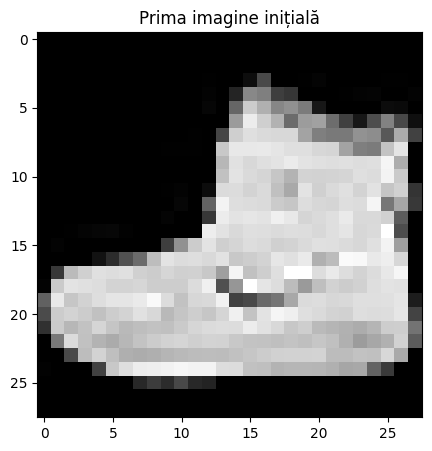

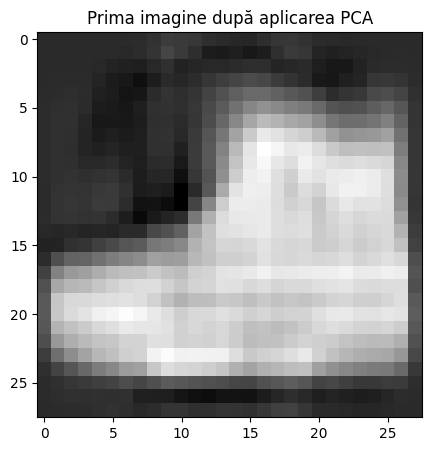

In [ ]:
from sklearn.decomposition import PCA

# Reshape x_train to 2D
x_train_flat = x_train.reshape(x_train.shape[0], -1)

pca = PCA(n_components=50)
dataIn2D = pca.fit_transform(x_train_flat)
reconstructed_image_pca = pca.inverse_transform(dataIn2D[0]).reshape(28, 28)

plt.figure(figsize=(5, 5))
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title("Prima imagine inițială")
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(reconstructed_image_pca, cmap='gray')
plt.title("Prima imagine după aplicarea PCA")
plt.show()

In [ ]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        # Extragere HOG
        feature= hog(img.squeeze(), orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
        hog_features.append(feature)
    return np.array(hog_features)

# Aplică HOG pe un subset de date
hog_features_train = apply_hog_fixed(x_train[:1000])
hog_features_test = apply_hog_fixed(x_test[:1000])
print(f"HOG Features Shape: {hog_features_train.shape}")
# Determine the correct shape for visualization
# hog_image_shape = hog_features_train[0].shape
# plt.imshow(hog_features_train[0].reshape(hog_image_shape), cmap='gray')
# plt.title("Prima imagine din setul de antrenament după prelucrare HOG")
# plt.show()

HOG Features Shape: (1000, 144)


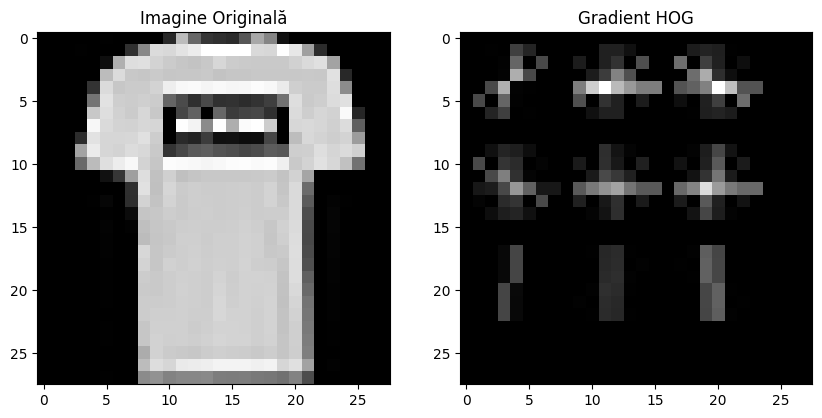

In [20]:
image_sample = x_train[1].squeeze()
_, hog_image = hog(image_sample, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_sample, cmap='gray')
plt.title("Imagine Originală")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("Gradient HOG")
plt.show()
